# Forecasts and Simulations

## Preliminary Analysis

### Basic loading and type definitions

In [1210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from scipy.stats import pearsonr
from scipy import stats

In [1211]:
import warnings
warnings.filterwarnings('ignore')

In [1212]:
df = pd.read_excel('../Taller1/datos.xlsx')

In [1213]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [1214]:
df['year'] = pd.to_datetime(df['year'], format = '%Y').dt.to_period('Y')
df.set_index(['year'], inplace= True)

In [1215]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [1216]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [1217]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [1218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 672 entries, 1998 to 2021
Freq: A-DEC
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Produccion      672 non-null    float64 
 1   Reservas        672 non-null    float64 
 2   PIB             672 non-null    float64 
 3   Oil Prices      672 non-null    float64 
 4   pais            672 non-null    category
 5   log_produccion  672 non-null    float64 
 6   log_reservas    672 non-null    float64 
 7   log_pib         672 non-null    float64 
 8   log_oil_prices  672 non-null    float64 
dtypes: category(1), float64(8)
memory usage: 49.2 KB


### 3. Correlations

In [1219]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, 0.1), xycoords=ax.transAxes)

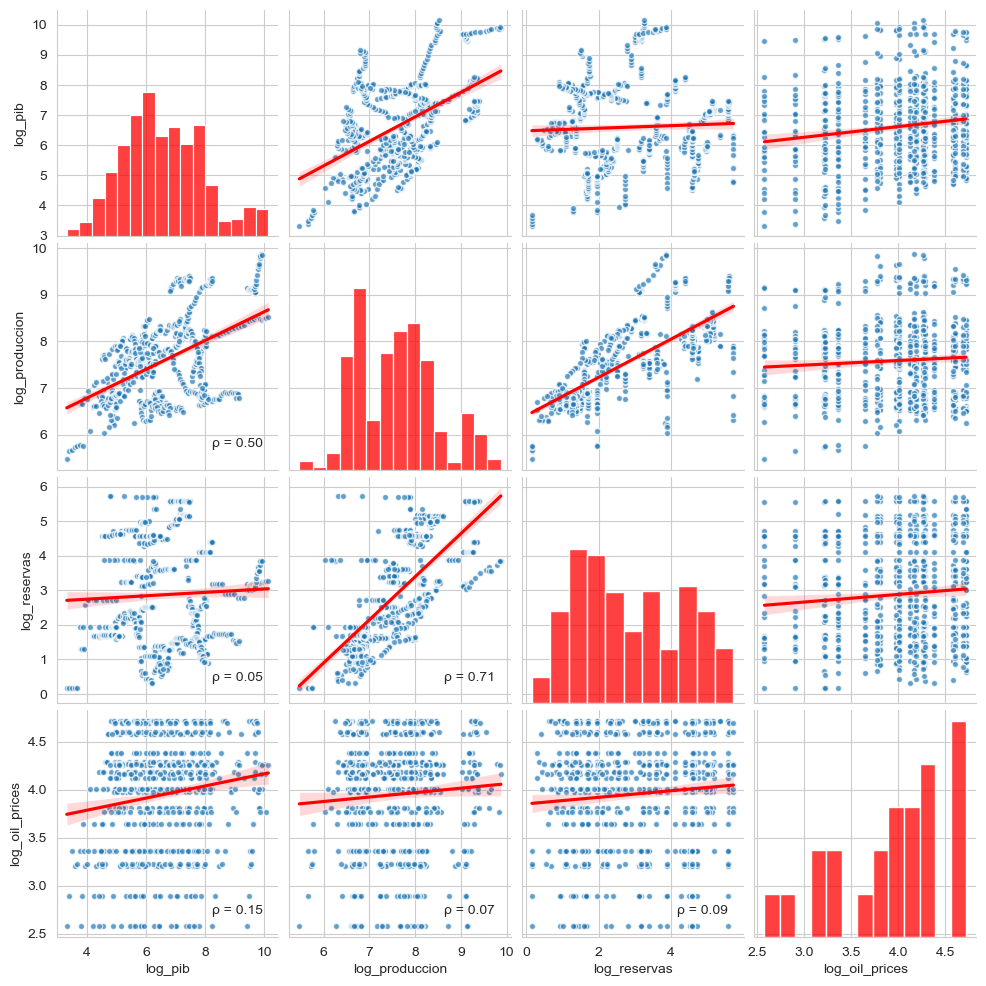

In [1220]:
g = sns.pairplot(df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']], kind = "reg", diag_kind='hist', diag_kws = {'color': 'red'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{"alpha": 0.7, "s": 20, 'edgecolors': 'white'}})
g.map_lower(corrfunc)
plt.show()

In [1221]:
dpi = 300

In [1222]:
g.savefig('./plots/correlogram_1,1,3.png', dpi = dpi)

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [1223]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)    
    return fig

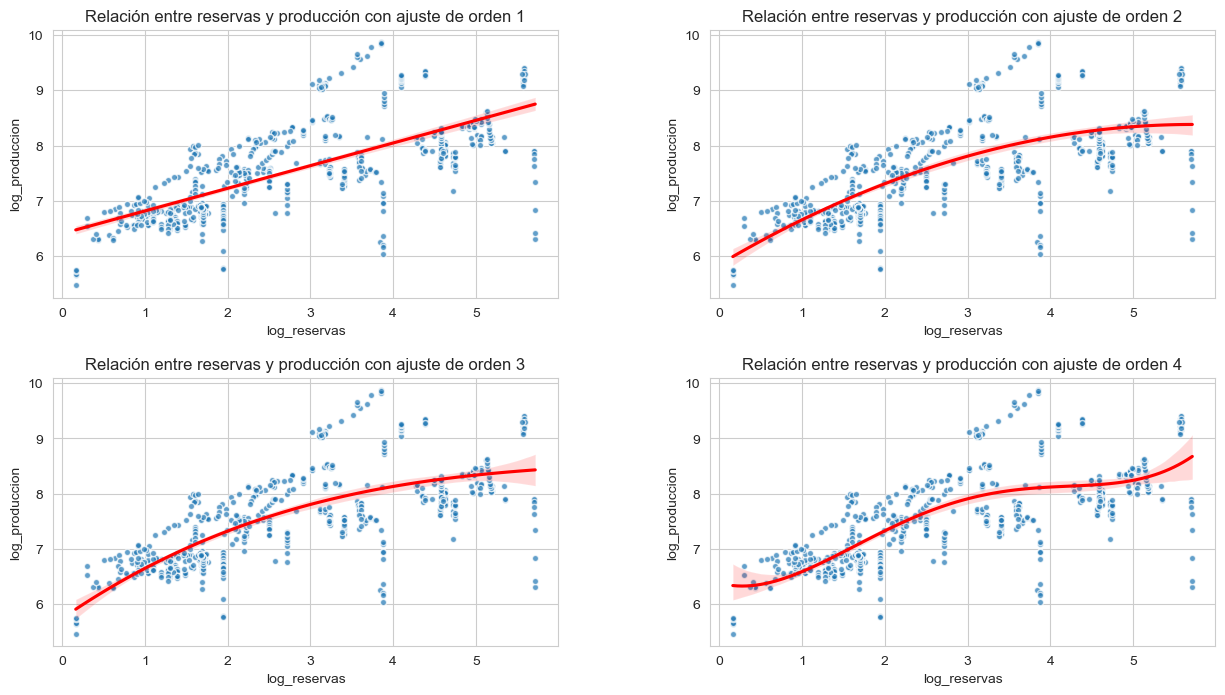

In [1224]:
fig = plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

In [1225]:
fig.savefig('./plots/scatter_1,1,4,1.png', dpi = dpi)

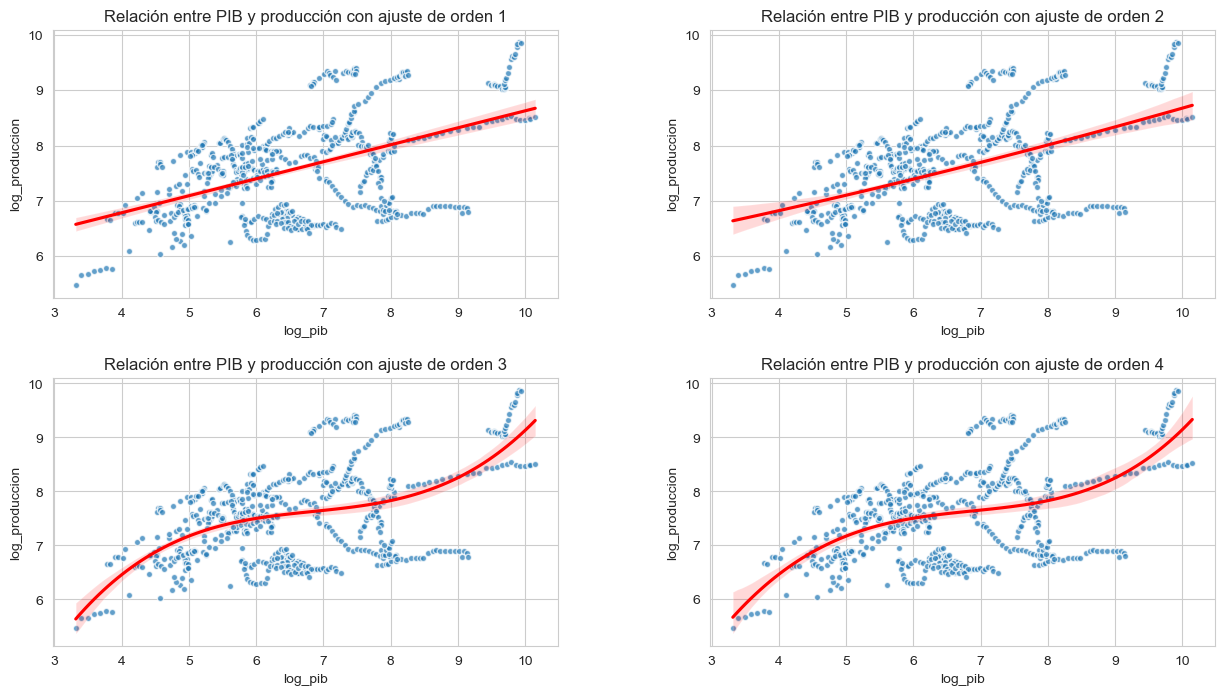

In [1226]:
fig = plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

In [1227]:
fig.savefig('./plots/scatter_1,1,4,2.png', dpi = dpi)

### 5. Boxplot

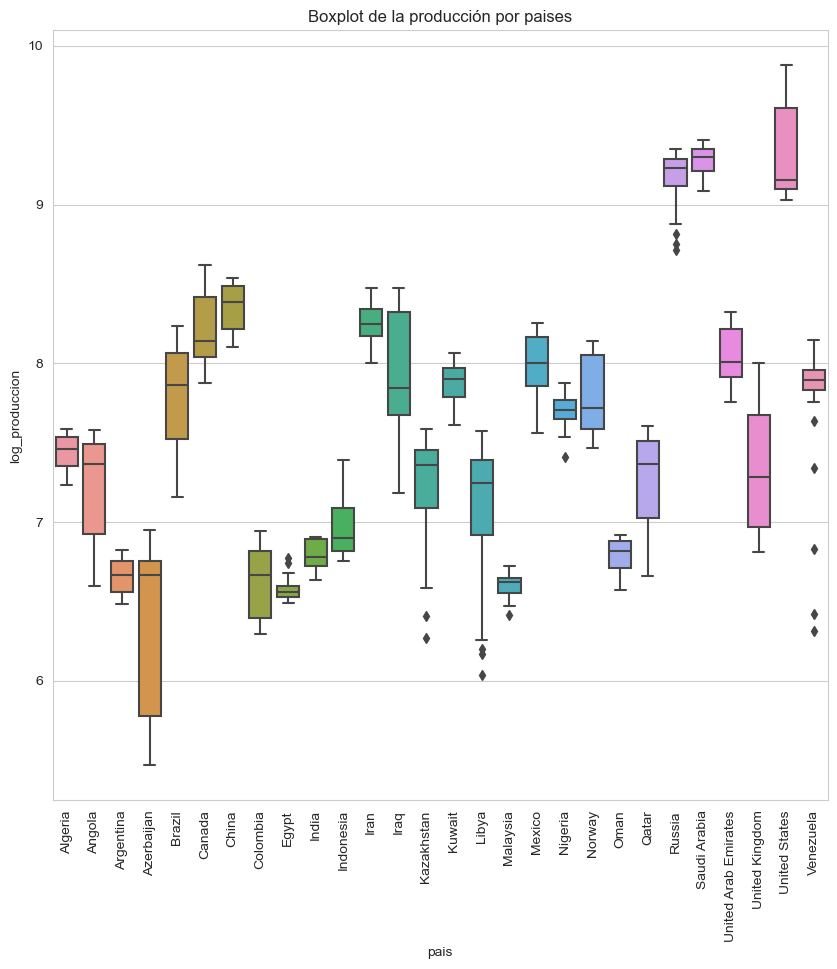

In [1230]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.savefig('./plots/boxplot1,1,5.png', dpi = dpi)

### 6. Model Estimation
### First Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [510]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [511]:
#Verifying we actually lost the first year's observation for all countries
df[df.index == '1998'].head()

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve
year,,,,,,,,,,
1998,1402.410959,9.2000,259.29310,13.126219,Algeria,7.245948,2.219203,5.557959,2.574612,NaN
1998,734.582192,5.4120,66.92613,13.126219,Angola,6.599302,1.688619,4.203589,2.574612,NaN
1998,916.684932,2.5882,627.23620,13.126219,Argentina,6.820764,0.950963,6.441323,2.574612,NaN
1998,236.773973,1.1780,27.56175,13.126219,Azerbaijan,5.467106,0.163818,3.316429,2.574612,NaN
1998,1282.627397,4.8000,1890.76100,13.126219,Brazil,7.156666,1.568616,7.544735,2.574612,NaN


In [512]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [513]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [514]:
df[df.pais == 'Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve,lag_resq
year,,,,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,1.029619,5.836476,2.574612,NaN,NaN
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,0.946704,5.793526,2.896366,1.029619,1.060116
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,0.946704,5.824505,3.361946,0.946704,0.896248
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,0.679048,5.841145,3.207360,0.946704,0.896248
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,0.559616,5.865877,3.223469,0.679048,0.461107
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,0.611009,5.904311,3.359650,0.559616,0.313170
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,0.611009,5.956268,3.643714,0.611009,0.373332
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,0.433080,5.999778,4.001568,0.611009,0.373332
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,0.433080,6.064787,4.183648,0.433080,0.187559


In [27]:
import statsmodels.api as sm

In [28]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     466.0
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.52e-188
Time:                        06:40:17   Log-Likelihood:                -366.10
No. Observations:                 644   AIC:                             742.2
Df Residuals:                     639   BIC:                             764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5577      0.159     28.

### Second Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \sum_{j=1}^{27}\gamma_{j}g_{j} +  \varepsilon_{it}
$$

In [29]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) 

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     419.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        06:40:17   Log-Likelihood:                 192.95
No. Observations:                 644   AIC:                            -321.9
Df Residuals:                     612   BIC:                            -178.9
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Aquí iría el análisis

### 7. In sample prediction

In [30]:
predictions = np.exp(model2.predict(df[df.index == '2021']).values)
labels = df[df.index == '2021']['Produccion '].values
errors = predictions - labels

In [31]:
results = pd.DataFrame(data = {'pais': df[df.index=='2021']['pais'], 'produccion':  labels, 'pred_prod': predictions, 'residuals': errors})
results

,pais,produccion,pred_prod,residuals
year,,,,
2021,Algeria,1415.129339,1885.236710,470.107371
2021,Angola,1196.686957,1583.729017,387.042060
2021,Argentina,702.330031,771.184064,68.854032
2021,Azerbaijan,716.735073,912.253896,195.518823
2021,Brazil,3689.416939,2759.453086,-929.963854
2021,Canada,5537.451003,4273.100038,-1264.350965
2021,China,4993.069739,6070.072293,1077.002554
2021,Colombia,764.186095,873.139099,108.953005
2021,Egypt,659.821906,800.743607,140.921701


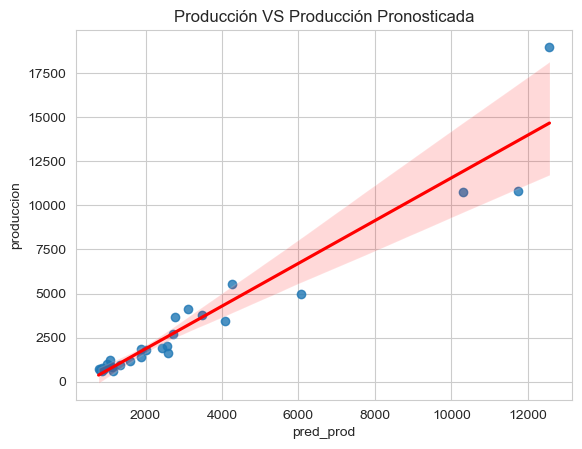

In [32]:
sns.set_style('whitegrid')
sns.regplot(x = results['pred_prod'], y = results['produccion'], line_kws = {'color': 'red'})
plt.title('Producción VS Producción Pronosticada')
plt.savefig('./plots/regplot1,1,6.png', dpi = dpi)

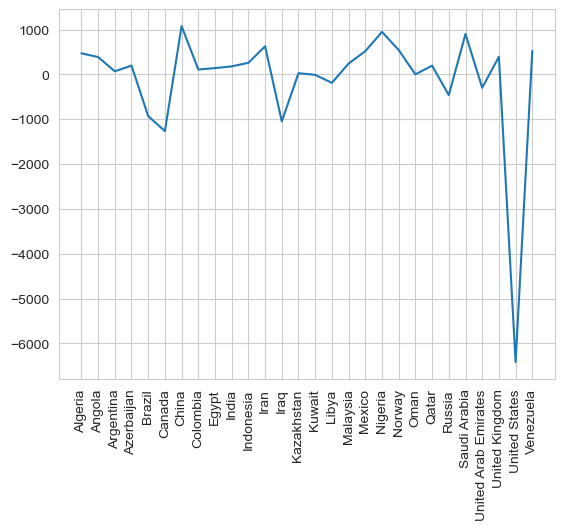

In [33]:
plt.plot( results['pais'], errors)
plt.gca().set_xticklabels(results.pais.values)
plt.xticks(rotation=90)
plt.show()

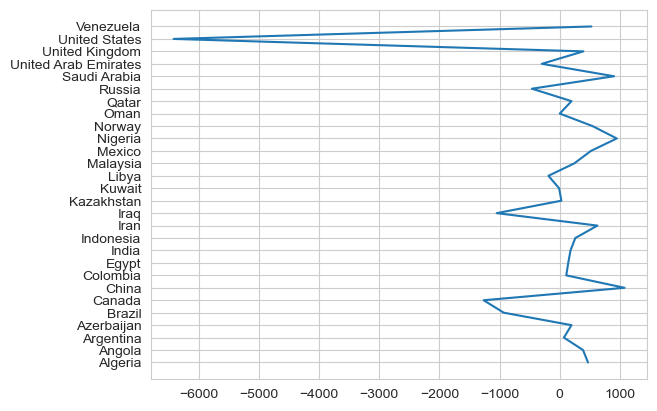

In [34]:
plt.plot(errors, results['pais'])


In [35]:
# Ufff pasó algo feo con Estados Unidos 

In [36]:
#Cuál se verá mejor?

## Intervals and Densities

In [391]:
pib = np.log(710.2)
oil = np.log(70.8)
reserve = 0.92

$$
\varepsilon_{it}\sim N(0, \sigma^2) 
$$

### 1.1 Error estimation without simulation

In [392]:
import pyarrow

In [616]:
#df.reset_index(inplace=True)
#df.to_csv('./first.csv')
#df.to_parquet('./first.parquet')

In [1115]:
df = pd.read_parquet('./first.parquet')

In [1116]:
df.set_index(['year'], inplace= True)

In [1117]:
np.std(model2.resid)

0.17932614263406607

In [1118]:
mean = 0
std =  np.std(model2.resid)

$$
margin\_of\_error = z^{*} \left(\frac{\sigma}{\sqrt{n}}\right)
$$

In [1119]:
n = len(df)
n_root = np.sqrt(n)

In [1120]:
z_star = stats.norm.ppf(0.975)

In [1121]:
margin_of_error = z_star*(std/n_root)

In [1122]:
margin_of_error

0.013558356884098502

In [1123]:
df.drop(['log_reservas', 'lag_reserve', 'lag_resq'],axis = 1, inplace= True)

In [1128]:
original_2021_value = df.loc[(df.pais == 'Colombia') & (df.index == '2021'),['Reservas'] ].values

In [1129]:
df.loc[(df.pais == 'Colombia') & (df.index == '2021'),['Reservas'] ] = reserve

In [1130]:
df[df.pais =='Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices
year,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,5.836476,2.574612
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,5.793526,2.896366
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,5.824505,3.361946
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,5.841145,3.207360
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,5.865877,3.223469
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,5.904311,3.359650
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,5.956268,3.643714
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,5.999778,4.001568
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,6.064787,4.183648


In [1131]:
df['log_reservas'] = np.log(df.Reservas)

In [1132]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [1133]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [1134]:
df[df.pais =='Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq
year,,,,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,5.836476,2.574612,1.029619,NaN,NaN
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,5.793526,2.896366,0.946704,1.029619,1.060116
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,5.824505,3.361946,0.946704,0.946704,0.896248
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,5.841145,3.207360,0.679048,0.946704,0.896248
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,5.865877,3.223469,0.559616,0.679048,0.461107
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,5.904311,3.359650,0.611009,0.559616,0.313170
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,5.956268,3.643714,0.611009,0.611009,0.373332
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,5.999778,4.001568,0.433080,0.611009,0.373332
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,6.064787,4.183648,0.433080,0.433080,0.187559


In [1135]:
std

0.17932614263406607

In [1136]:
new_pred = (model2.predict(df.loc[(df.index == '2021')&(df.pais =='Colombia')]).values)
new_pred_norm = np.exp(new_pred)
new_pred_norm

array([873.13909935])

In [1137]:
lower = new_pred - (2*std)
upper = new_pred + (2*std)
print(f"For the theorical normal distribution of the errors, the forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {np.exp(lower)[0]} and {np.exp(upper)[0]}")

For the theorical normal distribution of the errors, the forecast for production is 873.1390993544351,
with confidence intervals: 609.9900177955197 and 1249.8104306307446


### It can be noted that given that the second model's independent variables are only lags of the reserves and not the actual reserves, there is no change on the prediction when changing the value of R for time t. Nevertheless, we'll do the experiment of changing the value of the reserves for the previous period, t-1, to see the actual effect on production in time t, of a drastic reduction in the reserves of the previous year

In [1138]:
df.drop(['log_reservas', 'lag_reserve', 'lag_resq'],axis = 1, inplace= True)

In [1139]:
df.loc[(df.pais == 'Colombia') & (df.index == '2021'),['Reservas'] ] = original_2021_value
df.loc[(df.pais == 'Colombia') & (df.index == '2020'),['Reservas'] ] = reserve

In [1140]:
df['log_reservas'] = np.log(df.Reservas)
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)
df['lag_resq'] = np.square(df['lag_reserve'])

In [1143]:
new_pred = (model2.predict(df.loc[(df.index == '2021')&(df.pais =='Colombia')]).values)
new_pred_norm = np.exp(new_pred)
new_pred_norm

array([542.66166567])

In [1144]:
lower = new_pred - (2*std)
upper = new_pred + (2*std)
print(f"For the theorical normal distribution of the errors, the forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {np.exp(lower)[0]} and {np.exp(upper)[0]}")

For the theorical normal distribution of the errors, the forecast for production is 542.6616656722712,
with confidence intervals: 379.11278895323437 and 776.7653636884556


In [1145]:
old_prediction = 873.13909935
new_prediction = new_pred_norm
rate_of_change = 100*(old_prediction - new_prediction)/old_prediction
rate_of_change

array([37.84934542])

###  With this experiment production dropped in t to 542.66. Given that the previous prediction was 873.13, this meant a drop of 37.85% in production. 

### 1.2 Error estimation with simulation

In [1146]:
seed = np.random.seed(42)

In [1147]:
all_errors = []
all_intervals = []
for i in [50,500,10000]:
    sampled_errors = np.random.normal(mean, std, i)
    sample_added = np.exp(sampled_errors + new_pred)
    all_errors.append(sample_added)
    density = np.percentile(sample_added, [2.5,97.5])
    all_intervals.append(density)
titles = ['50 simulaciones', '500 simulaciones', '10000 simulaciones']

In [1148]:
for sims, ci in zip([50,500,10000],all_intervals):
    print(f'At {sims} simulations, we predict a value of {new_pred_norm}, and a confidence interval of {ci} ')

At 50 simulations, we predict a value of [542.66166567], and a confidence interval of [387.42040449 718.68426257] 
At 500 simulations, we predict a value of [542.66166567], and a confidence interval of [394.16218421 778.90552776] 
At 10000 simulations, we predict a value of [542.66166567], and a confidence interval of [381.1336968 772.1770985] 


In [1149]:
def plot_densities(n_plots: int, data: list, confidence_intervals: list, titles: list, prediction: float):
    fig, ax =plt.subplots(n_plots,1, figsize=(10,10), sharex = False)
    for i in range(len(data)):
        ax[i].set_title(titles[i])
        sns.histplot(data[i], ax = ax[i], stat = 'density', kde = True, bins = 100) 
        ax[i].axvline(confidence_intervals[i][0], color='r', linestyle='--', lw=2)
        ax[i].axvline(confidence_intervals[i][1], color='r', linestyle='--', lw=2)
        ax[i].axvline(prediction, color = 'g', lw = 4)
    fig.show()
    fig.tight_layout(pad=2.0)
    return fig

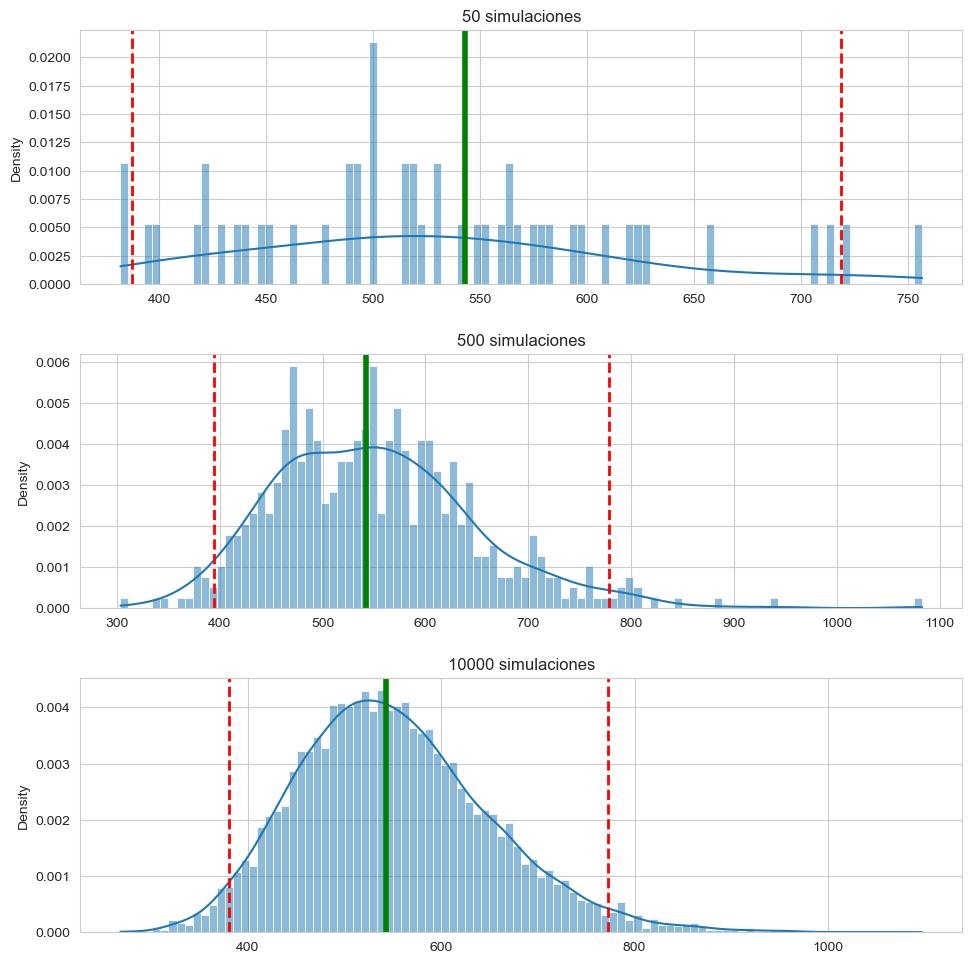

In [1151]:
fig =plot_densities(3, all_errors, all_intervals, titles, new_pred_norm)
fig.savefig('./plots/density_1,2,3.png', dpi= dpi)

### 1.4 Uncertain distribution of the errors

In [1152]:
import random

In [1153]:
residuals = model2.resid

In [1154]:
non_par_errors = random.choices(residuals, k = 10000)

In [1155]:
norm_errors = np.exp(non_par_errors+ new_pred)

In [1156]:
density = np.percentile(norm_errors, [2.5,97.5])
density

array([382.06494905, 750.2963354 ])

In [1157]:
print(f"The forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {np.exp(lower)[0]} and {np.exp(upper)[0]}")

The forecast for production is 542.6616656722712,
with confidence intervals: 379.11278895323437 and 776.7653636884556


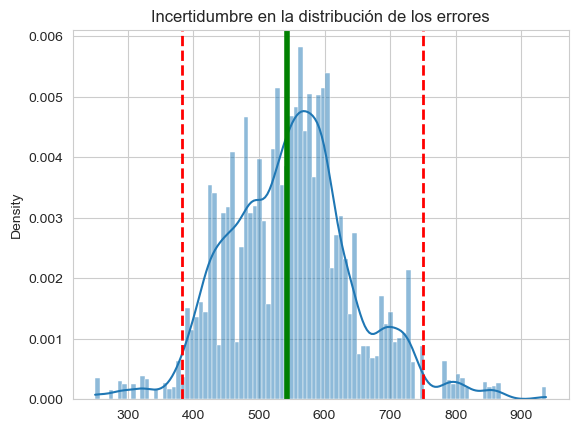

In [1158]:
sns.histplot(norm_errors,  stat = 'density', kde = True, bins = 100) 
plt.axvline(density[0], color='r', linestyle='--', lw=2)
plt.axvline(density[1], color='r', linestyle='--', lw=2)
plt.axvline(new_pred_norm, color = 'g', lw = 4)
plt.title('Incertidumbre en la distribución de los errores')
plt.savefig('./plots/density_1,2,5.png', dpi = dpi)

### 1.6 Uncertainty on parameters and errors

In [1159]:
coef_var = model2.cov_params()
betahat = model2.params

In [1160]:
RBetas = np.random.multivariate_normal(betahat, coef_var, size=10000) #generamos una distribucón normal multinomial
non_par_errors = random.choices(residuals, k = 10000)

In [1161]:
act_values = df[(df.pais =='Colombia')& (df.index == '2021')]

In [1162]:
act_values

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq
year,,,,,,,,,,,
2021,764.186095,2.036,710.2137,70.8315,Colombia,6.638811,6.565566,4.260304,0.710987,-0.083382,0.006952


In [1163]:
log_prod_list = []

In [1164]:
for i, j in zip(RBetas, non_par_errors):
    #intercept = i[0], col_dummy = i[7], log_oil_price = i[-1], log_gdp = i[-2], lag_res_sq = i[-3], lag_res = i[-4]
    new_estimate = i[0] + i[-1]*act_values.log_oil_prices + i[-2]*act_values.log_pib + i[-3]*act_values.lag_resq + i[-4]*act_values.lag_reserve + i[7] + j
    log_prod_list.append(new_estimate.values)    

In [1165]:
norm_preds = np.exp(log_prod_list)

In [1166]:
density = np.percentile(norm_preds, [2.5,97.5])
density

array([373.95943489, 772.06460324])

In [1167]:
print(f"The forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {density[0]} and {density[1]}")

The forecast for production is 542.6616656722712,
with confidence intervals: 373.9594348935947 and 772.0646032360639


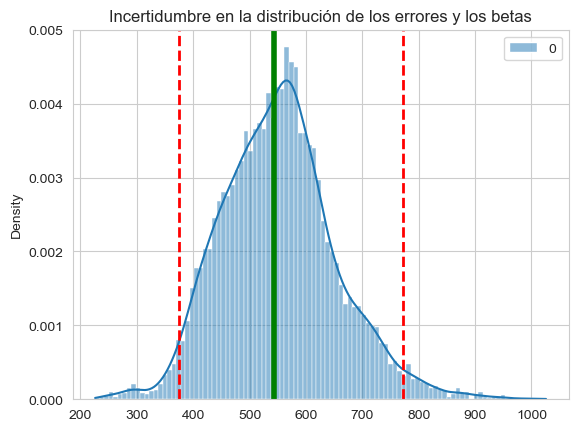

In [1168]:
sns.histplot(norm_preds,  stat = 'density', kde = True, bins = 100) 
plt.axvline(density[0], color='r', linestyle='--', lw=2)
plt.axvline(density[1], color='r', linestyle='--', lw=2)
plt.axvline(new_pred_norm, color = 'g', lw = 4)
plt.title('Incertidumbre en la distribución de los errores y los betas')
plt.savefig('./plots/density_1,2,7.png', dpi = dpi)

### 1.8 Heteroskedacity with known parameters

In [1169]:
betahats = model2.params
residuals = model2.resid
residuals_sq = np.square(residuals)

In [1170]:
df = df.dropna()

In [1171]:
df['residuals_sq'] = residuals_sq

In [1172]:
df

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq,residuals_sq
year,,,,,,,,,,,,
1999,1388.601370,9.200,267.5905,18.108219,Algeria,7.236052,5.589458,2.896366,2.219203,2.219203,4.924864,0.006808
2000,1433.025287,9.200,277.7589,28.845275,Algeria,7.267543,5.626753,3.361946,2.219203,2.219203,4.924864,0.000740
2001,1513.892645,9.200,286.0917,24.713763,Algeria,7.322440,5.656312,3.207360,2.219203,2.219203,4.924864,0.000005
2002,1617.653051,9.200,302.1128,25.115096,Algeria,7.388732,5.710800,3.223469,2.219203,2.219203,4.924864,0.002196
2003,1784.043024,9.200,323.8649,28.779103,Algeria,7.486637,5.780326,3.359650,2.219203,2.219203,4.924864,0.016146
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,2066.046795,300.878,357.1842,54.886916,Venezuela,7.633392,5.878252,4.005275,5.706705,5.703626,32.531347,0.012035
2018,1539.316118,302.250,287.0995,71.612593,Venezuela,7.339094,5.659829,4.271271,5.711254,5.706705,32.566480,0.004778
2019,927.705271,302.809,191.3250,64.198474,Venezuela,6.832714,5.253974,4.161979,5.713102,5.711254,32.618428,0.170183


In [1173]:
aux_mod= sm.formula.ols('residuals_sq ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(aux_mod.summary()) 

                            OLS Regression Results                            
Dep. Variable:           residuals_sq   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     7.500
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           6.57e-27
Time:                        18:24:19   Log-Likelihood:                 1053.4
No. Observations:                 644   AIC:                            -2043.
Df Residuals:                     612   BIC:                            -1900.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [1174]:
aux_params = aux_mod.params

In [1175]:
act_values = df[(df.pais =='Colombia')& (df.index == '2021')]

In [1176]:
act_values

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq,residuals_sq
year,,,,,,,,,,,,
2021,764.186095,2.036,710.2137,70.8315,Colombia,6.638811,6.565566,4.260304,0.710987,-0.083382,0.006952,0.017765


In [1177]:
new_variance = aux_mod.predict(act_values).values[0]

In [1178]:
new_variance

0.04411342674839103

In [1179]:
sampled_errors = np.random.normal(0, (new_variance), 10000)

In [1180]:
sample_added = np.exp(sampled_errors + new_pred)

In [1181]:
density = np.percentile(sample_added, [2.5,97.5])
density

array([497.46509411, 590.88467544])

In [1182]:
sample_added

array([563.39179902, 541.51825061, 520.10479264, ..., 544.49252285,
       542.2289466 , 581.66269289])

In [1183]:
print(f"The forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {density[0]} and {density[1]}")

The forecast for production is 542.6616656722712,
with confidence intervals: 497.46509411117165 and 590.8846754435937


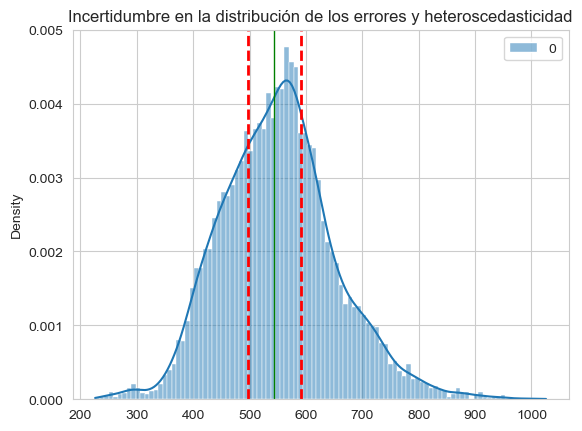

In [1184]:
sns.histplot(norm_preds,  stat = 'density', kde = True, bins = 100) 
plt.axvline(density[0], color='r', linestyle='--', lw=2)
plt.axvline(density[1], color='r', linestyle='--', lw=2)
plt.axvline(new_pred_norm, color = 'g', lw = 1)
plt.title('Incertidumbre en la distribución de los errores y heteroscedasticidad')
plt.savefig('./plots/density_1,2,9.png', dpi = dpi)

# Trend, Stationality and Cycles

##  AR, MA, ARMA

In [1186]:
df = pd.read_excel('./IPC.xlsx')

In [1187]:
df.index = pd.to_datetime(df['Fecha'], format = "%YYYY-%MM-%DD").dt.to_period("M")

In [1188]:
df.drop('Fecha', axis =1, inplace= True)

In [1189]:
df["ln_ipc_sa"] = np.log(df["IPC(SA)"])

In [1190]:
df['ln_ipc_sa_diff'] = df['ln_ipc_sa'].diff(1)*100

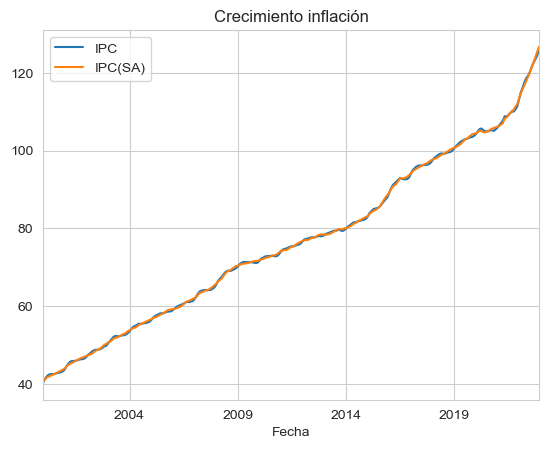

In [1191]:
df[['IPC', 'IPC(SA)']].plot()
plt.title('Crecimiento inflación')
plt.show()

In [1192]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

In [1193]:
df2 = df.dropna()

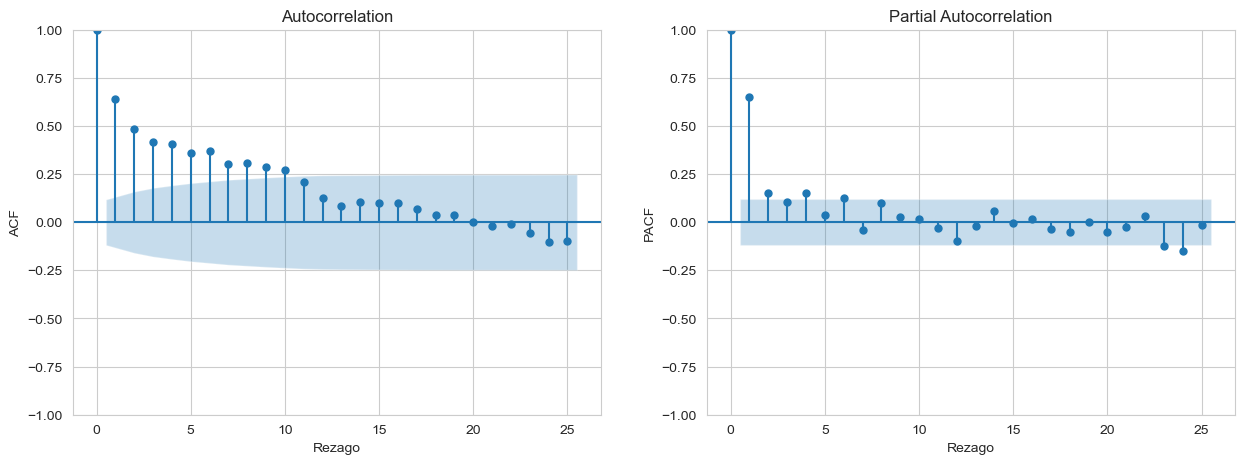

In [1194]:
fig, ax =plt.subplots(1,2, figsize=(15, 5), sharex = False) 

#FIG 1
plot_acf(df2['ln_ipc_sa_diff'], ax = ax[0], alpha = 0.05)
ax[0].set_xlabel('Rezago', fontsize=10)
ax[0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(df2['ln_ipc_sa_diff'], ax = ax[1], alpha = 0.05, method = "ols")
ax[1].set_xlabel('Rezago', fontsize=10)
ax[1].set_ylabel('PACF', fontsize=10)

fig.savefig("./plots/autocorrs,2,2,1,bc.png")

In [1195]:
df

,IPC,IPC(SA),ln_ipc_sa,ln_ipc_sa_diff
Fecha,,,,
2000-01,40.30,40.587011,3.703448,NaN
2000-02,41.23,41.165761,3.717607,1.415877
2000-03,41.93,41.659551,3.729531,1.192379
2000-04,42.35,41.869772,3.734564,0.503348
2000-05,42.57,42.121123,3.740549,0.598522
...,...,...,...,...
2022-08,121.50,121.540830,4.800250,1.126269
2022-09,122.63,122.751366,4.810161,0.991064
2022-10,123.51,124.064253,4.820800,1.063870


In [1196]:
df['ln_ipc_sa_diff_1'] =df['ln_ipc_sa_diff'].shift(1) 

In [1197]:
df['ln_ipc_sa_diff_2'] =df['ln_ipc_sa_diff'].shift(2)

In [1198]:
df

,IPC,IPC(SA),ln_ipc_sa,ln_ipc_sa_diff,ln_ipc_sa_diff_1,ln_ipc_sa_diff_2
Fecha,,,,,,
2000-01,40.30,40.587011,3.703448,NaN,NaN,NaN
2000-02,41.23,41.165761,3.717607,1.415877,NaN,NaN
2000-03,41.93,41.659551,3.729531,1.192379,1.415877,NaN
2000-04,42.35,41.869772,3.734564,0.503348,1.192379,1.415877
2000-05,42.57,42.121123,3.740549,0.598522,0.503348,1.192379
...,...,...,...,...,...,...
2022-08,121.50,121.540830,4.800250,1.126269,0.963344,0.805523
2022-09,122.63,122.751366,4.810161,0.991064,1.126269,0.963344
2022-10,123.51,124.064253,4.820800,1.063870,0.991064,1.126269


In [1199]:
X1 = sm.add_constant(df[['ln_ipc_sa_diff_1', 'ln_ipc_sa_diff_2']])
Y = df["ln_ipc_sa_diff"]

In [1200]:
model1 = sm.OLS(Y, X1, missing = 'drop').fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_ipc_sa_diff   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     102.7
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           6.67e-34
Time:                        18:27:59   Log-Likelihood:                 53.140
No. Observations:                 273   AIC:                            -100.3
Df Residuals:                     270   BIC:                            -89.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1240      0.024  

In [1201]:
betas = model1.params

In [1202]:
periods = pd.date_range('2023', periods=12, freq= "M").to_period("M")

In [1203]:
df.drop('IPC', axis = 1, inplace = True)

In [1204]:
df

,IPC(SA),ln_ipc_sa,ln_ipc_sa_diff,ln_ipc_sa_diff_1,ln_ipc_sa_diff_2
Fecha,,,,,
2000-01,40.587011,3.703448,NaN,NaN,NaN
2000-02,41.165761,3.717607,1.415877,NaN,NaN
2000-03,41.659551,3.729531,1.192379,1.415877,NaN
2000-04,41.869772,3.734564,0.503348,1.192379,1.415877
2000-05,42.121123,3.740549,0.598522,0.503348,1.192379
...,...,...,...,...,...
2022-08,121.540830,4.800250,1.126269,0.963344,0.805523
2022-09,122.751366,4.810161,0.991064,1.126269,0.963344
2022-10,124.064253,4.820800,1.063870,0.991064,1.126269


In [1205]:
for i in periods:
    yt  = betas['const'] + betas['ln_ipc_sa_diff_1']*df.loc[i-1,'ln_ipc_sa_diff'] + betas['ln_ipc_sa_diff_2']*df.loc[i-2,'ln_ipc_sa_diff'] 
    yt_1 = df.loc[i-1, 'ln_ipc_sa_diff']
    yt_2 = df.loc[i-2, 'ln_ipc_sa_diff']
    ln_ipc_sa = (df.loc[i-2,'ln_ipc_sa'] + df.loc[i-1,'ln_ipc_sa_diff']/100)
    IPCSA = np.exp(ln_ipc_sa)
    df.loc[i] = [IPCSA, ln_ipc_sa, yt, yt_1, yt_2]

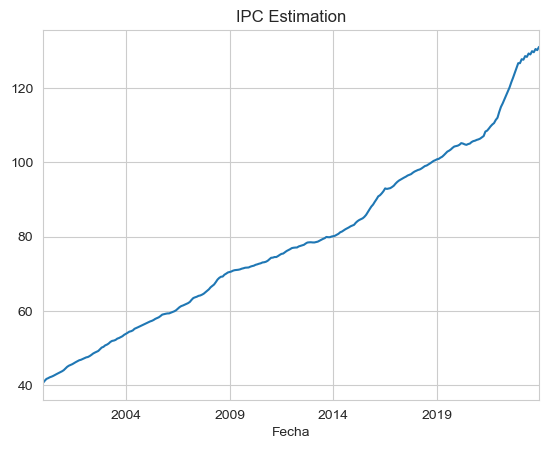

In [1206]:
df['IPC(SA)'].plot()
plt.title("IPC Estimation")
plt.savefig("./plots/2,2,1,e.png")

In [1207]:
df.loc['2023-12'] 

IPC(SA)             131.050913
ln_ipc_sa             4.875586
ln_ipc_sa_diff        0.423009
ln_ipc_sa_diff_1      0.429023
ln_ipc_sa_diff_2      0.437084
Name: 2023-12, dtype: float64

In [1208]:
feb_infl = ((df.loc['2023-02']['IPC(SA)'] - df.loc['2022-02']['IPC(SA)'])/df.loc['2022-02']['IPC(SA)'])*100
feb_infl

11.178761303912644

# Esto dio tan bueno que mañana cuando el DANE diga que la inflación fue 14 no nos vamos a ganar el bono :(